In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [2]:
data = pd.read_csv("spam.csv", encoding="latin-1")
data = data[['v1', 'v2']]
data.columns = ['label', 'message']

##Division de datos y vectorizacion

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    data['message'], data['label'],
    test_size=0.2,
    random_state=42,
    stratify=data['label']
)

vectorizer = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1,2),
    max_features=5000
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

## Entrenamiento de modelos

In [4]:
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=5000,
    ngram_range=(1,2)
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [5]:
models = {
    "Naive Bayes": MultinomialNB(),
    "SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        random_state=42
    )
}

In [6]:
results = []

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    results.append({
        "Modelo": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, pos_label='spam'),
        "Recall": recall_score(y_test, y_pred, pos_label='spam'),
        "F1-score": f1_score(y_test, y_pred, pos_label='spam')
    })

results_df = pd.DataFrame(results)
results_df

,Modelo,Accuracy,Precision,Recall,F1-score
0,Naive Bayes,0.971300,0.991597,0.791946,0.880597
1,SVM,0.982960,0.985075,0.885906,0.932862
2,Random Forest,0.977578,1.000000,0.832215,0.908425


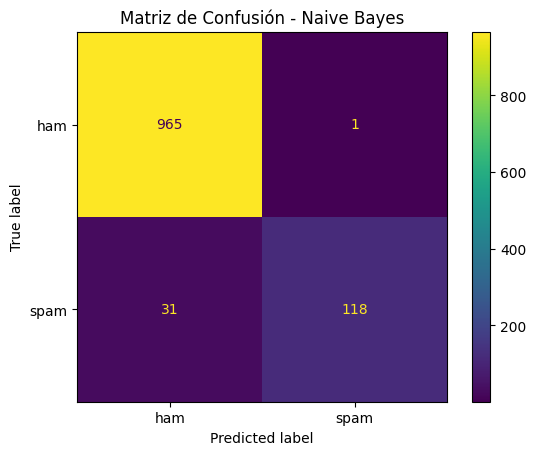

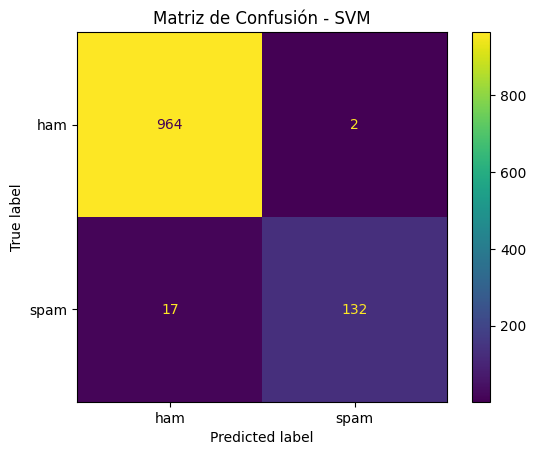

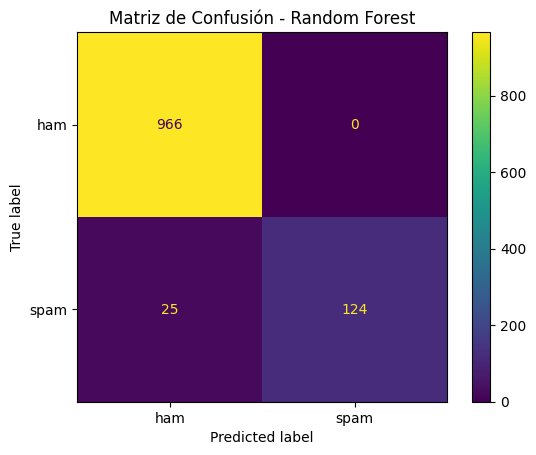

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    cm = confusion_matrix(y_test, y_pred, labels=['ham', 'spam'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=['ham', 'spam'])

    disp.plot()
    plt.title(f"Matriz de Confusión - {name}")
    plt.savefig(f"confusion_matrix_{name}.png", dpi=300, bbox_inches="tight")
    plt.show()


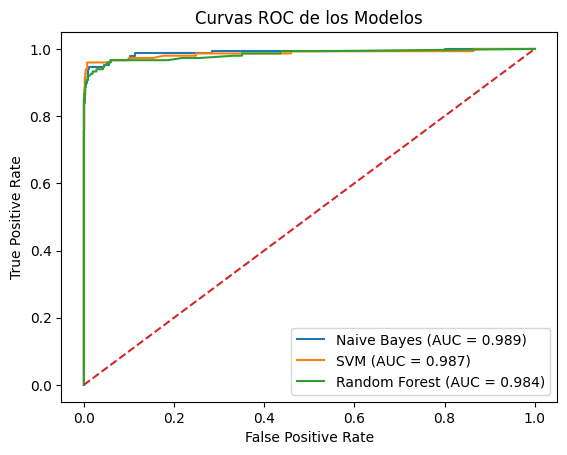

In [8]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convertir etiquetas a binario
y_test_bin = label_binarize(y_test, classes=['ham', 'spam']).ravel()

plt.figure()

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)

    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test_tfidf)[:, 1]
    else:
        y_scores = model.decision_function(X_test_tfidf)

    fpr, tpr, _ = roc_curve(y_test_bin, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC de los Modelos")
plt.savefig("roc_curves_models.png", dpi=300, bbox_inches="tight")
plt.legend()
plt.show()
